# Calculating short spectra

We start by importing the necessary libraries. Including the module ``specwizard.Phys`` that contains the ``ReadPhys`` function that contains a set of physical constants.

In [1]:
import specwizard
import numpy as np
from specwizard import Phys
import matplotlib.pyplot as plt
constants = Phys.ReadPhys()

As always, the first step of for doing calculations. We initilize the ``specwizard.Build_Input`` module to generate the ``Wizard`` dictionary, in this case we will load it from a ``YAML`` file using the ``read_from_yml`` function. 

In [2]:
build_input = specwizard.Build_Input()

In [3]:
Wizard = build_input.read_from_yml(yml_file='../Examples/notebooks/Wizard.yml')

Warning! SightLength NOT found. Setting default value: 1


Now we can simply run ``specwizard.GenerateShortSpectra``.  This will read the simulation data and according to the parameters given in the ``Wizard`` dictionary will form a sight line, and load all the necessary information for the calculation of the optical depth.  Later the sightline particles physical properties are projected into velocity pixels. These properties will be weighted by the total mass of particles that are contributing to a specific pixel, by the fraction of each element and by ion. Finally with this projection we will calculate the Optical Depth of each ion that was asked in the ``Wizard `` dictionary. 

When we run ``specwizard.GenerateShortSpectra`` it will return ``optical_depth,projected_data,sim_data`` which are python dictionaries that contains the informaiton of each of the step described above. If one desire to just use one of the data the assigned python charecter ``_`` can be used, for example if only we care about the optical depth we can use ``OD,_,_ = specwizard.GenerateShortSpectra(Wizard)``



In [4]:
optical_depth,projected_data,snap_data = specwizard.GenerateShortSpectra(Wizard=Wizard)

/cosma7/data/dp004/dc-aram1/swpythonenv/lib64/python3.9/site-packages/unyt/array.py:1832: RuntimeWarning: invalid value encountered in sqrt
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


After this, we already have optical depths of the ions indicated in the Wizard dictionary. We can just plot the flux. $F=e^{-\tau}$

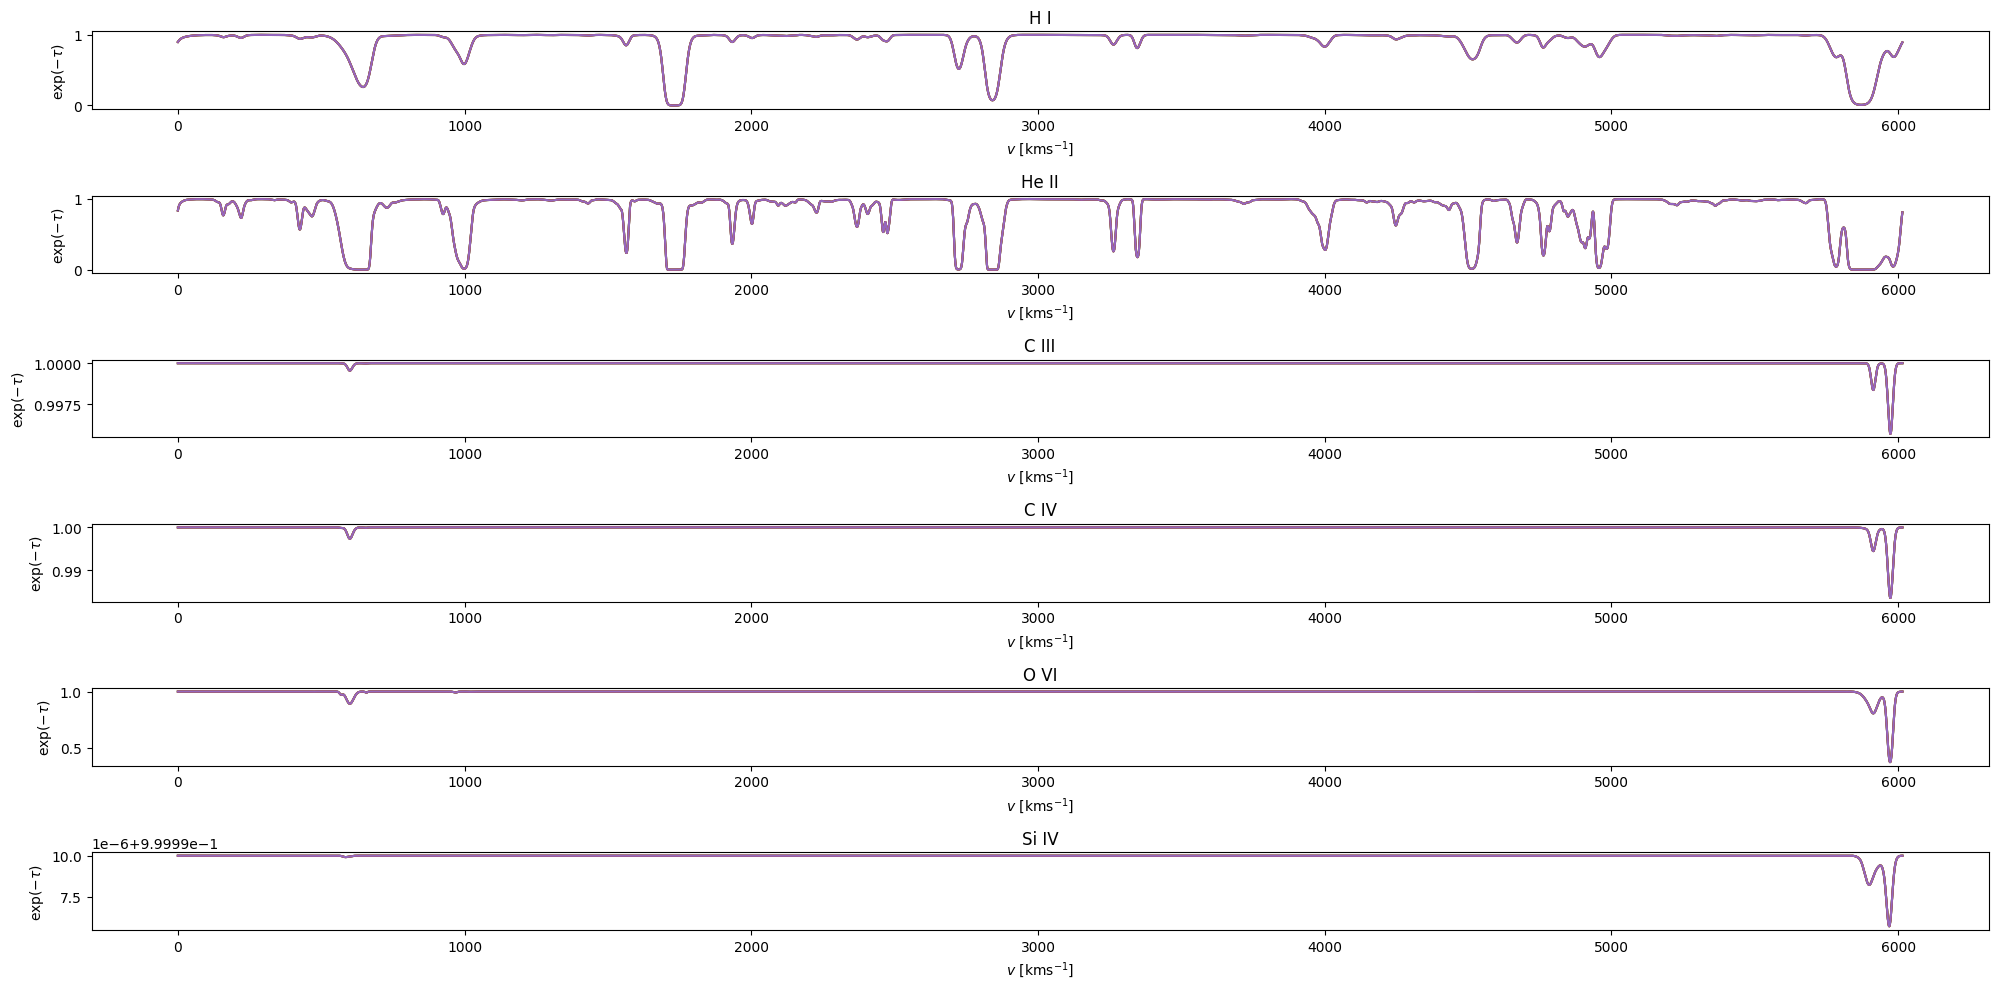

In [5]:
elementnames = Wizard["ionparams"]["Ions"] # We get the name of the ions that we used 
Numof_Ions = len(elementnames)
fig, ax  = plt.subplots(Numof_Ions, 1, figsize = (20, 10))

for (i, ion) in zip (np.arange(Numof_Ions), elementnames):
#    ax[i].set_xlim(0, box_kms)
    try:
        for j in range(5):
            ax[i].plot(( np.exp(-optical_depth[ion]['Optical depths']['Value'])),label = 'sightline# '+str(j))
    except:
        continue
    element, ion_name = ion
    title = r"{}".format(ion_name)
    ax[i].set_title(title)
    ax[i].set_ylabel(r"$\exp(-\tau)$")
    ax[i].set_xlabel(r"$v\ [{\rm km s}^{-1}]$")
   # ax[i].set_xlim(6200,6800)
fig.tight_layout()
fig.show()

Let's explore the other contents returned by GenerateShortSpectra. First lets note that use the python library [unyt](https://unyt.readthedocs.io/en/stable/usage.html) to handle the units of physical quantities. This way is very easy to keep track and covert them. eg:

In [6]:
snap_data['Methods']['to_physical'](snap_data["Particles"]["Positions"])

unyt_array([[24.9357252 , 24.84931381,  0.11923278],
       [24.82301615, 24.85645885,  0.1346299 ],
       [24.84984992, 24.86186289,  0.07395332],
       ...,
       [24.89036187, 24.89628423, 49.87654161],
       [24.89419373, 24.92099043, 49.88383424],
       [24.89545967, 24.92426295, 49.85259369]], 'Mpc')

Here we can see that the at the unit of the content of the array is in kf/Mpc**3, if we want to transform it into a cgs we can simply use:

In [7]:
snap_data["Particles"]["Positions"]["Value"].in_cgs()

unyt_array([[1.04504291e+26, 1.04142146e+26, 4.99698200e+23],
       [1.04031933e+26, 1.04172090e+26, 5.64226707e+23],
       [1.04144392e+26, 1.04194738e+26, 3.09934398e+23],
       ...,
       [1.04314176e+26, 1.04338996e+26, 2.09029919e+26],
       [1.04330235e+26, 1.04442538e+26, 2.09060482e+26],
       [1.04335540e+26, 1.04456253e+26, 2.08929555e+26]], 'cm')

Important to note is that this quantity could be in co-moving coordinates we can check for this in it's info 

In [11]:
snap_data["Particles"]["Positions"]['Info']

{'VarDescription': 'Positions from the simulation particle data. The units are in co-moving and units are descrived in the unyt array.',
 'aexp-scale-exponent': 1.0,
 'h-scale-exponent': -1.0}

To transform it to physical this or any quantity we can give it to the function ``to_physical`` inside the ``Methods`` section in any dictionary of the outputs. 

In [9]:
to_phys = snap_data['Methods']['to_physical']
print(to_phys(snap_data["Particles"]["Positions"]).in_cgs())

[[7.69436082e+25 7.66769705e+25 3.67913912e+23]
 [7.65958244e+25 7.66990178e+25 4.15424460e+23]
 [7.66786248e+25 7.67156929e+25 2.28196093e+23]
 ...
 [7.68036316e+25 7.68219061e+25 1.53902926e+26]
 [7.68154555e+25 7.68981415e+25 1.53925429e+26]
 [7.68193618e+25 7.69082394e+25 1.53829031e+26]] cm


To illustrate the outputs we will generate a set of plots that shows the different contents from the returned dictionaries. 

In [18]:
positions         = snap_data["Particles"]["Positions"]['Value']# We load the positions from the simulation data LOS 
densities         = snap_data["Particles"]["Densities"]['Value'].in_cgs() # We do the same for the density 
projected_density = projected_data["Mass-weighted"]['Densities']['Value'].in_cgs() # We load the Mass-weighted density from the projected pixel data. 
OD           = optical_depth[('Hydrogen', 'H I')]['Optical depths']['Value'].in_cgs() # We load the Optical depth


We can examine what is inside these fields: 

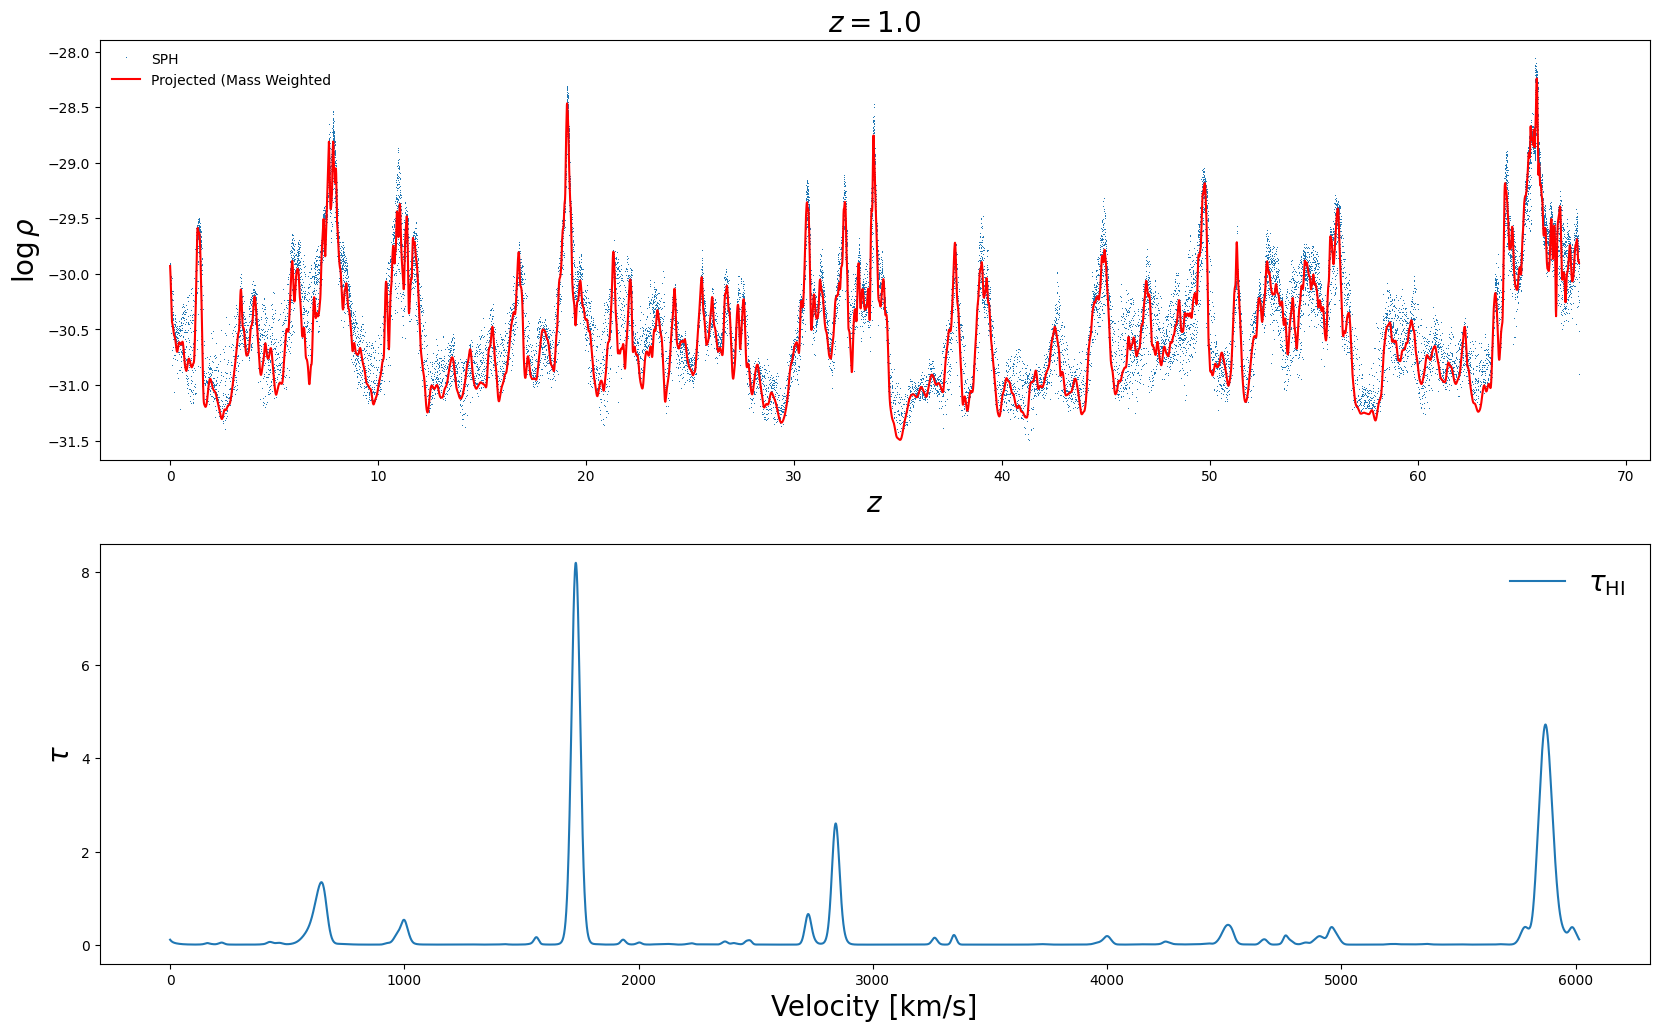

In [19]:

fontsize= 20
ix           = Wizard['sightline']["x-axis"] ; iy = Wizard['sightline']["y-axis"] ; iz = Wizard['sightline']["z-axis"]
elementnames = Wizard["ionparams"]["Ions"]
#
zpos = positions[:,iz]

# parameters of projection
pixz = projected_data["pixel"]["Value"] * np.arange(projected_data["npix"])
                   
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

title = r"$z=$"+str(round(Wizard["Header"]["Cosmo"]["Redshift"],2))

# plot particle density
ax[0].set_title(title, fontsize=fontsize)
ax[0].plot(zpos, np.log10(densities), ',', label='SPH')
ax[0].plot(pixz, np.log10(projected_density), color='r', label='Projected (Mass Weighted')
ax[0].legend(frameon=False)
ax[0].set_ylabel(r"$\log\rho$", fontsize=fontsize)
ax[0].set_xlabel(r"$z$", fontsize=fontsize)



ax[1].plot(OD, label=r'$\tau_{\mathrm{H I}}$')

ax[1].legend(frameon=False, fontsize=fontsize)



ax[1].set_ylabel(r"$\tau$", fontsize=fontsize)
ax[1].set_xlabel(r"Velocity [km/s]", fontsize=fontsize)

fig.show()

    




We can take a deeper look at the output ``project_data`` to understand better the output. We project the physical properties of the simulation particles into velocity pixels. This projection is weighted by the total mass of the particles contributing to a pixel, by it's element content and by the ion content. 

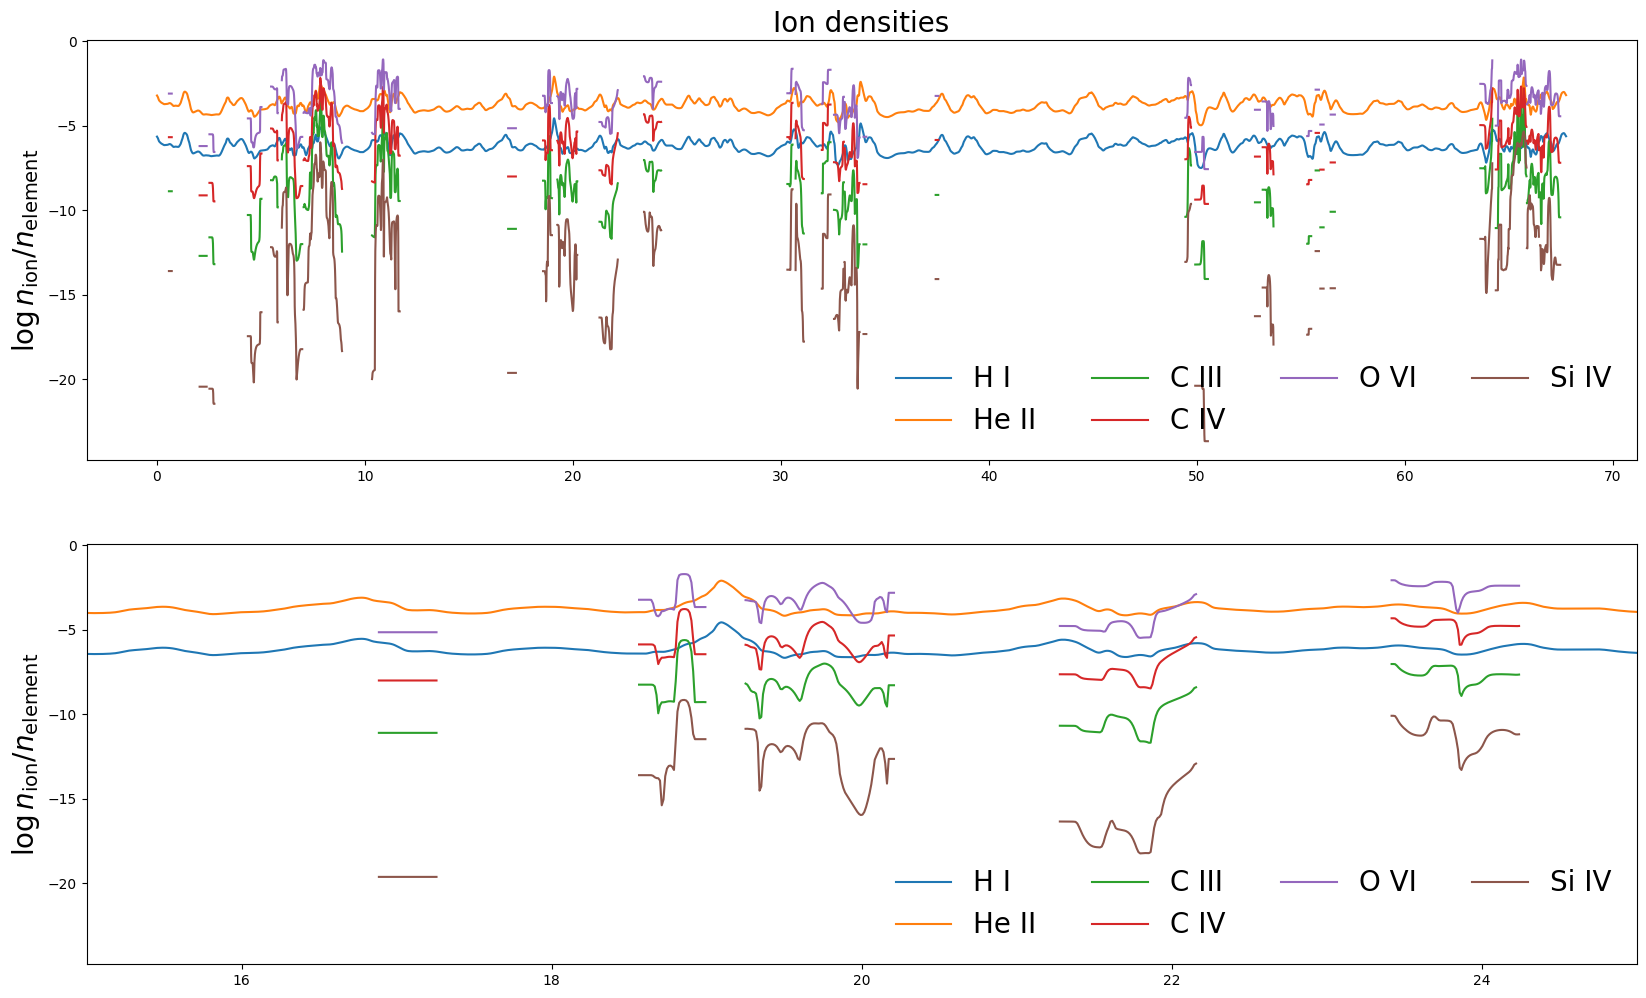

In [20]:
# plot ionization states
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
nelements = len(elementnames)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.CMRmap(np.linspace(0., 1., nelements+1))))
cycle    = plt.rcParams['axes.prop_cycle'].by_key()['color']
nsys     = np.arange(nelements)

# plot ion densities
ax[0].set_title("Ion densities", fontsize=fontsize)
for i in np.arange(2):
    for (isys, (element, ion)) in zip(nsys, elementnames):
        color               = cycle[isys]
        element_density     = projected_data["Element-weighted"][element]['Densities']['Value']
        ion_fraction        = projected_data["Ion-weighted"][ion]['Densities']['Value']
        ratio               = ion_fraction / element_density
        ax[i].plot(pixz, np.log10(ratio), color=color, label=r'{}'.format(ion))
    # ax[i].set_ylim(-7,1)
    ax[i].legend(frameon=False, fontsize=fontsize, ncol=4)
    ax[i].set_ylabel(r"$\log n_{\rm ion}/n_{\rm element}$", fontsize=fontsize)
ax[1].set_xlim(15, 25)
    
    
fig.show()